<a href="https://colab.research.google.com/github/Nagib005/Inverse_Design/blob/main/inverse_ana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import model_from_json, Sequential
from keras.layers import LeakyReLU
from keras.initializers import VarianceScaling, Zeros
from keras.optimizers import Adadelta

# --- Step 1: Load model architecture ---
with open("/content/drive/MyDrive/Circular_inverse/CircularRR_AOPS_inverse_model.json", "r") as json_file:
    model_json = json_file.read()

model = model_from_json(
    model_json,
    custom_objects={
        "Sequential": Sequential,
        "LeakyReLU": LeakyReLU,
        "VarianceScaling": VarianceScaling,
        "Zeros": Zeros
    }
)

# --- Step 2: Load model weights ---
model.load_weights("/content/drive/MyDrive/Circular_inverse/CircularRR_AOPS_inverse_model_weights.h5")

# --- Step 3: Compile the model ---
model.compile(
    loss='mean_squared_logarithmic_error',
    optimizer=Adadelta(learning_rate=0.1)
)

# --- Step 4: Load your CSV data ---
data = pd.read_csv("/content/drive/MyDrive/Circular_inverse/result_H.csv", header=None)
data = data.to_numpy().astype(np.float32)

# ✅ Step 5: Extract 1600 spectral points and 5 input parameters
X = np.abs(data[:, 0:1600])    # (samples, 1600)
y = data[:, 1600:1605]         # (samples, 5)

# --- Step 6: Split data (15% for test set) ---
_, X_test, _, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)

# --- Step 7: Standardize and reshape input for model ---
scaler = StandardScaler()
scaler.fit(X)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled[:, np.newaxis, :]  # Reshape to (samples, 1, 1600)

# --- Step 8: Evaluate the model ---
test_loss = model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test loss (MSLE): {test_loss:.6f}")

# --- Step 9: Make predictions ---
y_pred = model.predict(X_test_scaled)
print("Predicted input parameters shape (before squeeze):", y_pred.shape)

# --- Step 10: Format and Save predictions ---
y_pred = np.squeeze(y_pred)  # Shape becomes (samples, 5)

output = pd.DataFrame(np.hstack([y_test, y_pred]), columns=[
    'True_1', 'True_2', 'True_3', 'True_4', 'True_5',
    'Pred_1', 'Pred_2', 'Pred_3', 'Pred_4', 'Pred_5'
])

output.to_csv("/content/drive/MyDrive/Circular_inverse/inverse_predictions.csv", index=False)
print("Predictions saved to inverse_predictions.csv")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7756
Test loss (MSLE): 0.787133
692/692 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Predicted input parameters shape (before squeeze): (22119, 1, 5)
Predictions saved to inverse_predictions.csv


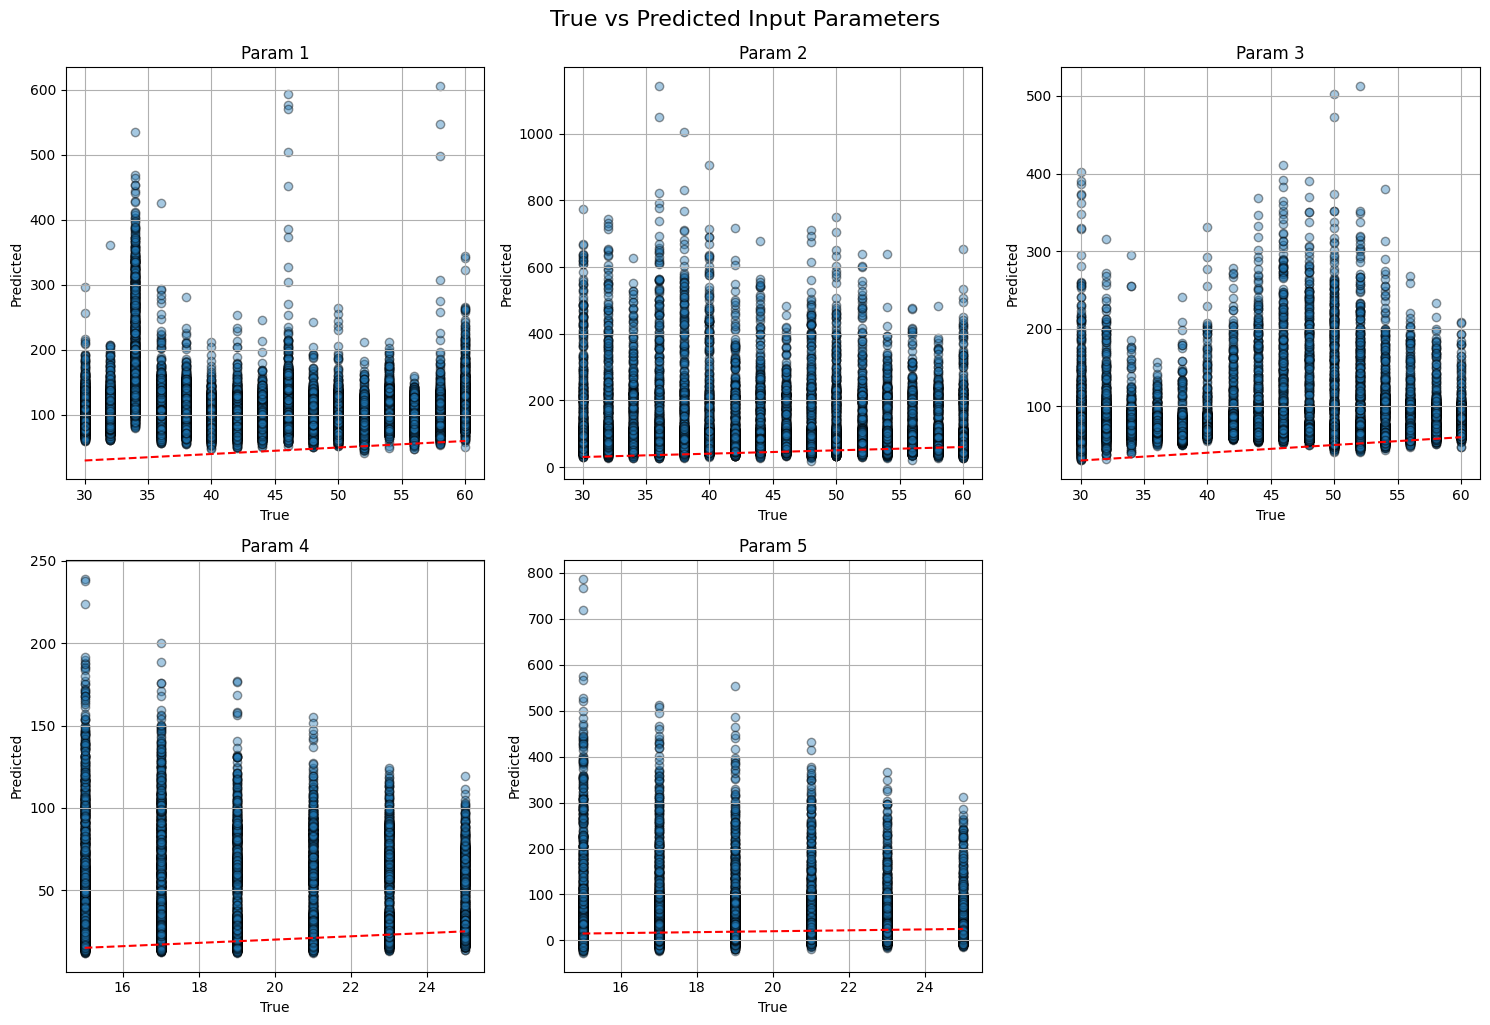

📊 Model Performance Summary (per parameter):

Parameter       MAE      RMSE    R² Score
  Param 1 63.893775 76.606207  -68.356840
  Param 2 56.429369 99.467898 -115.214938
  Param 3 34.012420 49.099834  -27.470160
  Param 4 15.005200 27.340130  -63.515166
  Param 5 24.391453 52.545284 -235.881461


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Step 1: Load the predictions ---
df = pd.read_csv("/content/drive/MyDrive/Circular_inverse/inverse_predictions.csv")

# Split true and predicted values
y_true = df.iloc[:, 0:5].values  # columns True_1 to True_5
y_pred = df.iloc[:, 5:10].values  # columns Pred_1 to Pred_5

param_names = ['Param 1', 'Param 2', 'Param 3', 'Param 4', 'Param 5']

# --- Step 2: Plot true vs predicted ---
plt.figure(figsize=(15, 10))

for i in range(5):
    plt.subplot(2, 3, i + 1)
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.4, edgecolor='k')
    plt.plot([y_true[:, i].min(), y_true[:, i].max()],
             [y_true[:, i].min(), y_true[:, i].max()],
             'r--', linewidth=1.5)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'{param_names[i]}')
    plt.grid(True)

plt.tight_layout()
plt.suptitle("True vs Predicted Input Parameters", fontsize=16, y=1.02)
plt.show()

# --- Step 3: Compute and print performance metrics ---
print("📊 Model Performance Summary (per parameter):\n")

summary = []

for i in range(5):
    mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
    r2 = r2_score(y_true[:, i], y_pred[:, i])
    summary.append([param_names[i], mae, rmse, r2])

# Display as a DataFrame
summary_df = pd.DataFrame(summary, columns=["Parameter", "MAE", "RMSE", "R² Score"])
print(summary_df.to_string(index=False))
